In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
# Load dataset
df = pd.read_csv('music_dataset.csv')

In [6]:
# Meta Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [7]:
df.isnull().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [8]:
# Removes all missing values
df = df.dropna()
print(df.isnull().sum())  # Should show all zeros

Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


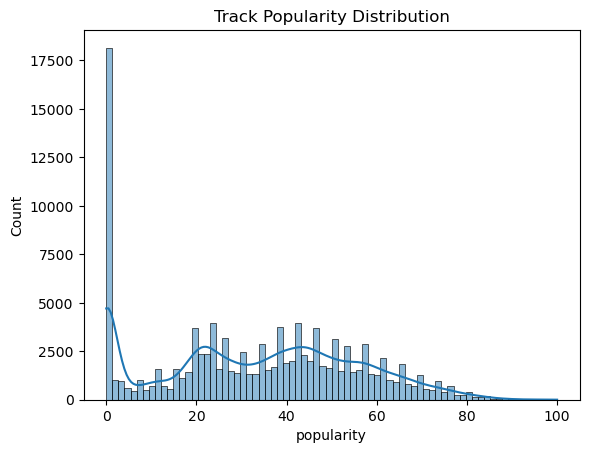

In [9]:
# Distribution of target variable
df.drop('Unnamed: 0', axis=1, inplace=True) #  Drop the column 'Unnamed'
sns.histplot(df['popularity'], kde=True)
plt.title('Track Popularity Distribution')
plt.show()

Number of tracks remaining: 97980


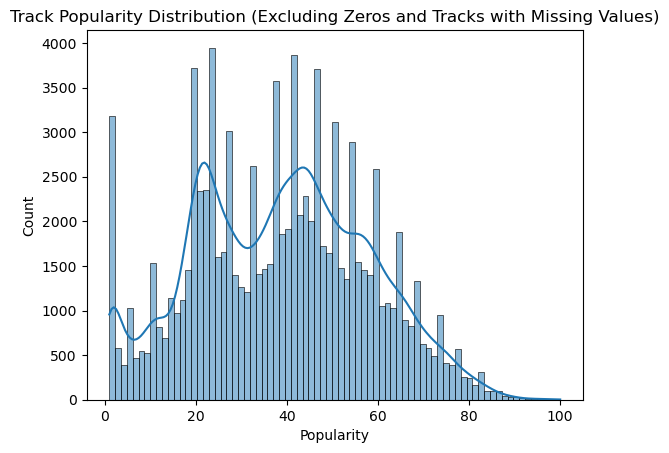

In [10]:
# Remove tracks with popularity = 0
df = df[df['popularity'] > 0]

# Print number of tracks remaining
print(f"Number of tracks remaining: {len(df)}")

# Plot the distribution of the target variable
sns.histplot(df['popularity'], kde=True)
plt.title('Track Popularity Distribution (Excluding Zeros and Tracks with Missing Values)')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()

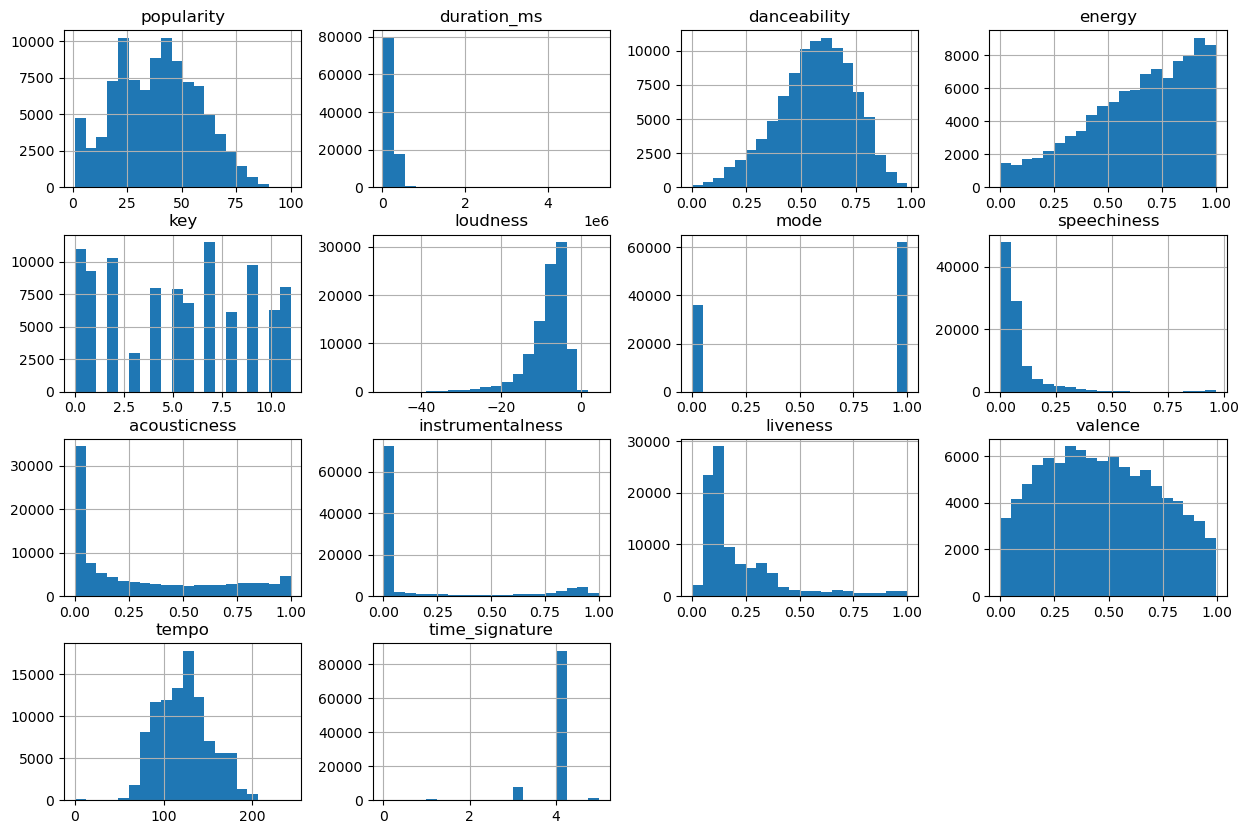

In [11]:
# Visualize numerical features without a popularity score of zero
df.hist(bins=20, figsize=(15, 10))
plt.show()

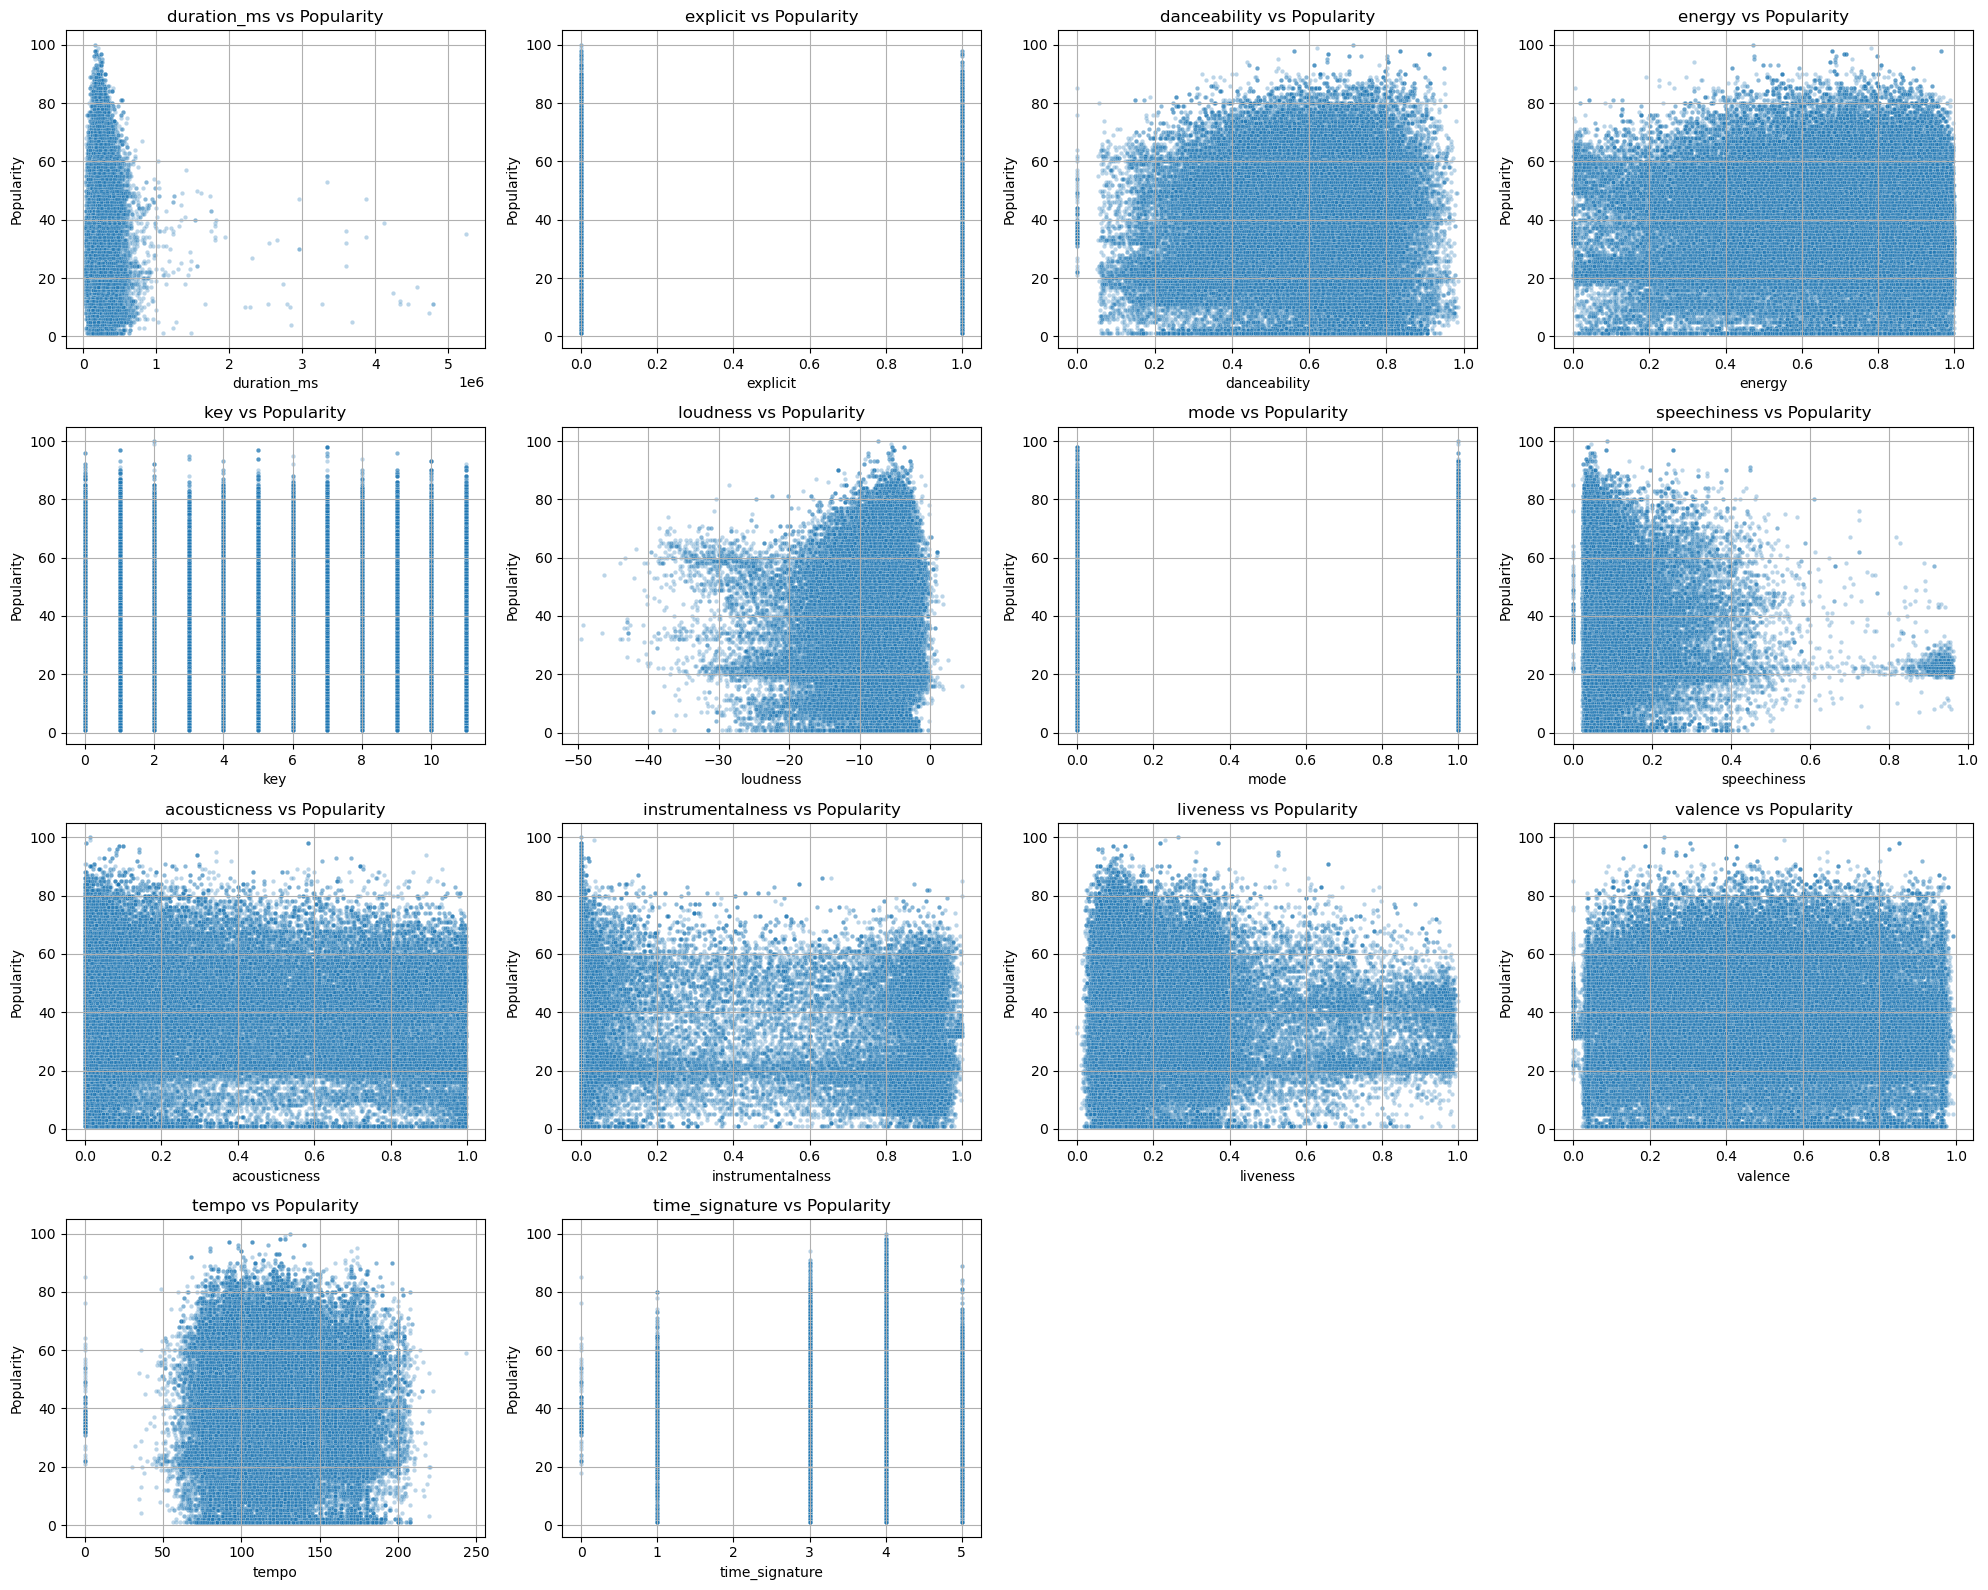

In [12]:
# Plot scatter plots of feature vs popularity without features of a popularity score of zero

features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence',
    'tempo', 'time_signature'
]

# Calculate how many rows and columns you need for subplots
n_features = len(features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.scatterplot(x=df[feature], y=df['popularity'], alpha=0.3, s=10)
    plt.title(f'{feature} vs Popularity')
    plt.xlabel(feature)
    plt.ylabel('Popularity')
    plt.grid(True)

plt.tight_layout()
plt.show()

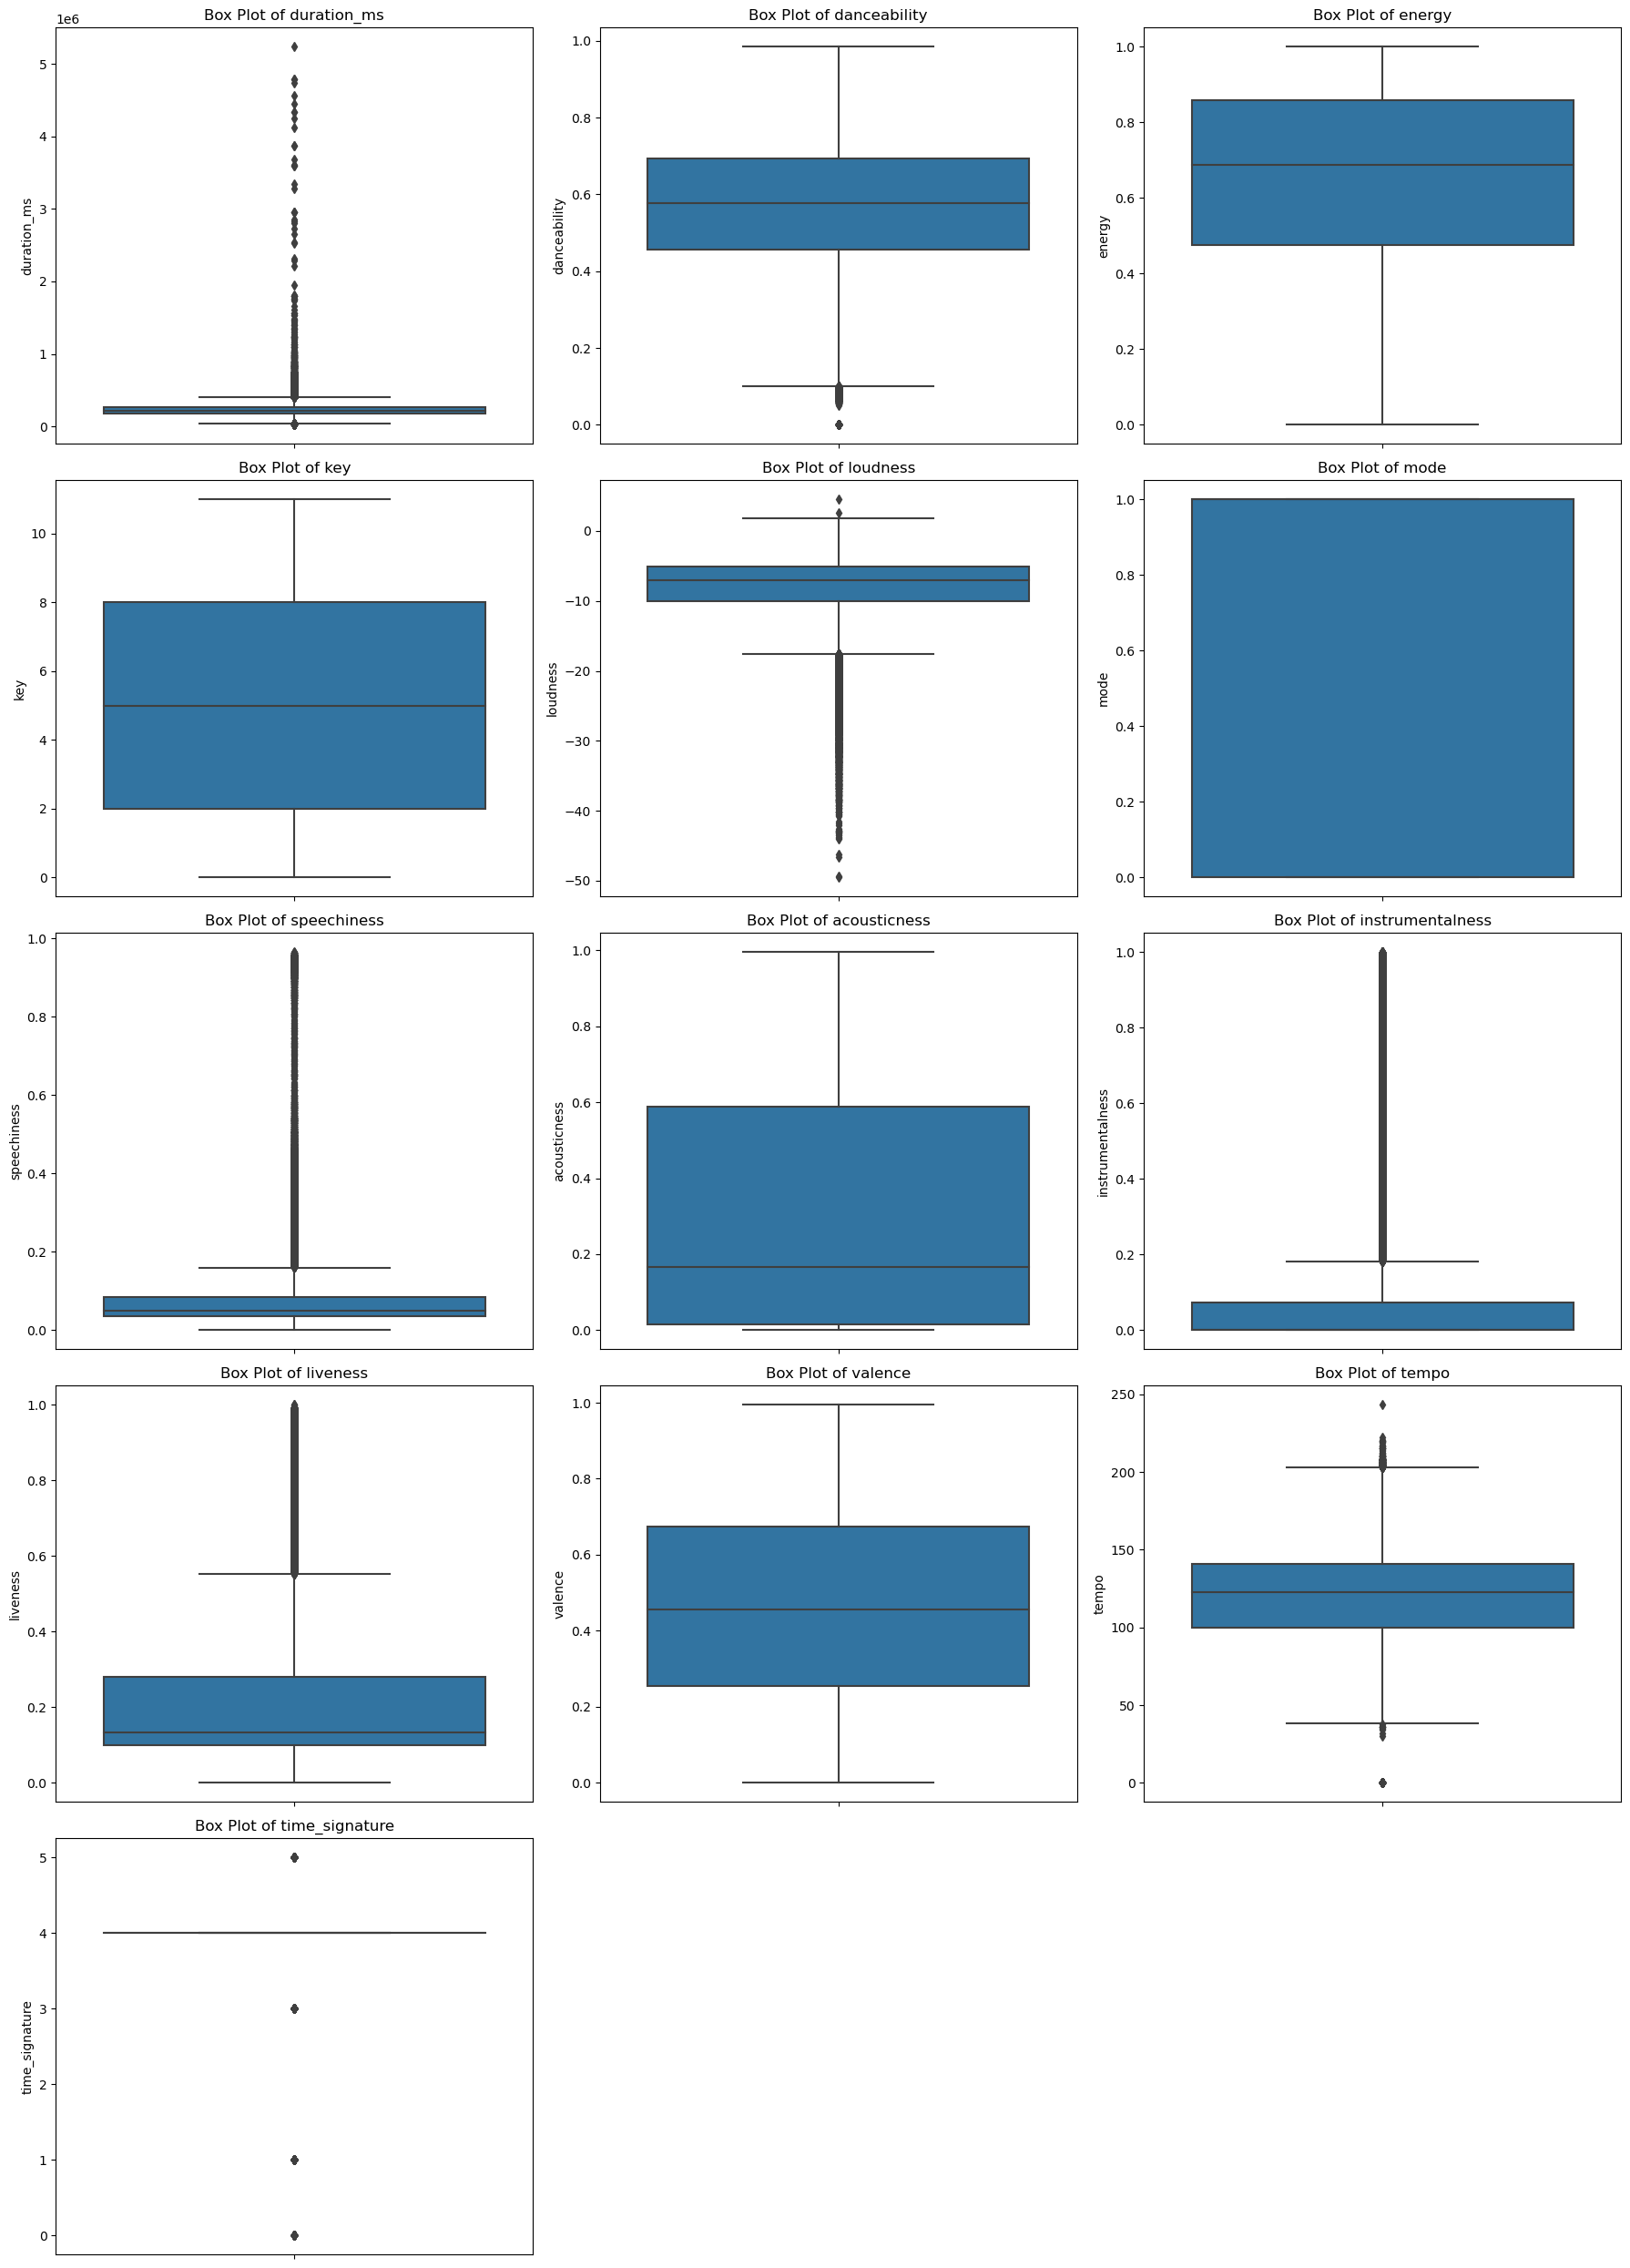

Outlier counts per feature:


duration_ms  danceability  energy  key  loudness  mode  speechiness  \
0         4627           564       0    0      5063     0        11413   

   acousticness  instrumentalness  liveness  valence  tempo  time_signature  
0             0             21516      7703        0    432           10094

In [13]:
# Get list of numerical features except the target (popularity)
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('popularity')

# Dictionary to store outlier counts
outlier_counts = {}

# Set up subplots
num_cols = 3
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols

plt.figure(figsize=(18, 5 * num_rows))

# Plot one box per feature and calculate outliers
for i, column in enumerate(numerical_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=df[column])
    plt.title(f'Box Plot of {column}')
    plt.ylabel(column)

    # IQR method for outliers
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outlier_counts[column] = len(outliers)

plt.tight_layout()
plt.show()

# Display outlier counts as a horizontal table
outlier_df = pd.DataFrame([outlier_counts])
print("Outlier counts per feature:")
display(outlier_df)



Model Testing: Decision Trees

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer

# Convert target into categorical classes
df['popularity_class'] = pd.cut(df['popularity'],
                                bins=[0, 33, 66, 100],
                                labels=['Low', 'Medium', 'High'])

# Define entropy function
def entropy(series):
    counts = series.value_counts(normalize=True)
    return -np.sum(counts * np.log2(counts + 1e-9))  # add epsilon to avoid log(0)

# Information Gain function
def information_gain(df, feature, target='popularity_class'):
    total_entropy = entropy(df[target])
    values = df[feature].unique()
    weighted_entropy = 0
    for v in values:
        subset = df[df[feature] == v]
        weighted_entropy += (len(subset) / len(df)) * entropy(subset[target])
    return total_entropy - weighted_entropy

# Bin numerical features (except popularity/popularity_class)
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('popularity')

binned_df = df.copy()

# Use 5 bins for simplicity
for col in numerical_columns:
    binned_df[col] = pd.qcut(binned_df[col], q=5, duplicates='drop')

# Calculate IG for all features
features = numerical_columns + ['explicit', 'key', 'mode', 'time_signature']
ig_scores = {}

for feature in features:
    try:
        ig = information_gain(binned_df, feature)
        ig_scores[feature] = ig
    except Exception as e:
        print(f"Error processing {feature}: {e}")

# Display results
ig_df = pd.DataFrame(sorted(ig_scores.items(), key=lambda x: x[1], reverse=True),
                     columns=['Feature', 'Information Gain'])

print(ig_df)

             Feature  Information Gain
0   instrumentalness          0.026797
1       acousticness          0.022359
2             energy          0.017654
3        duration_ms          0.011106
4           loudness          0.010792
5        speechiness          0.009084
6       danceability          0.008733
7            valence          0.005220
8           liveness          0.004822
9           explicit          0.002944
10             tempo          0.001319
11    time_signature          0.000946
12               key          0.000357
13              mode          0.000000


In [16]:
# Get top feature
top_feature = ig_df.iloc[0]['Feature']
print(f"Root node splits on: {top_feature}")

# Split the dataset by top feature bins
groups = binned_df.groupby(top_feature)

# Traverse each split and stop if pure
for value, group in groups:
    print(f"\nBranch: {top_feature} = {value}")
    class_counts = group['popularity_class'].value_counts()
    print("Class distribution:")
    print(class_counts)

    if len(class_counts) == 1:
        # Pure node: all examples are the same class
        print(f"✅ Pure node! All tracks are '{class_counts.idxmax()}'")
    else:
        print("❌ Not pure — would continue splitting in full tree.")


Root node splits on: instrumentalness

Branch: instrumentalness = (-0.001, 5.35e-06]
Class distribution:
Medium    22454
Low       12962
High       3776
Name: popularity_class, dtype: int64
❌ Not pure — would continue splitting in full tree.

Branch: instrumentalness = (5.35e-06, 0.000783]
Class distribution:
Medium    10347
Low        7347
High       1907
Name: popularity_class, dtype: int64
❌ Not pure — would continue splitting in full tree.

Branch: instrumentalness = (0.000783, 0.305]
Class distribution:
Medium    9510
Low       8510
High      1586
Name: popularity_class, dtype: int64
❌ Not pure — would continue splitting in full tree.

Branch: instrumentalness = (0.305, 1.0]
Class distribution:
Low       10743
Medium     8475
High        363
Name: popularity_class, dtype: int64
❌ Not pure — would continue splitting in full tree.


In [ ]:
from graphviz import Digraph

# Start a directed graph
dot = Digraph()
node_id = 0  # unique node ID tracker

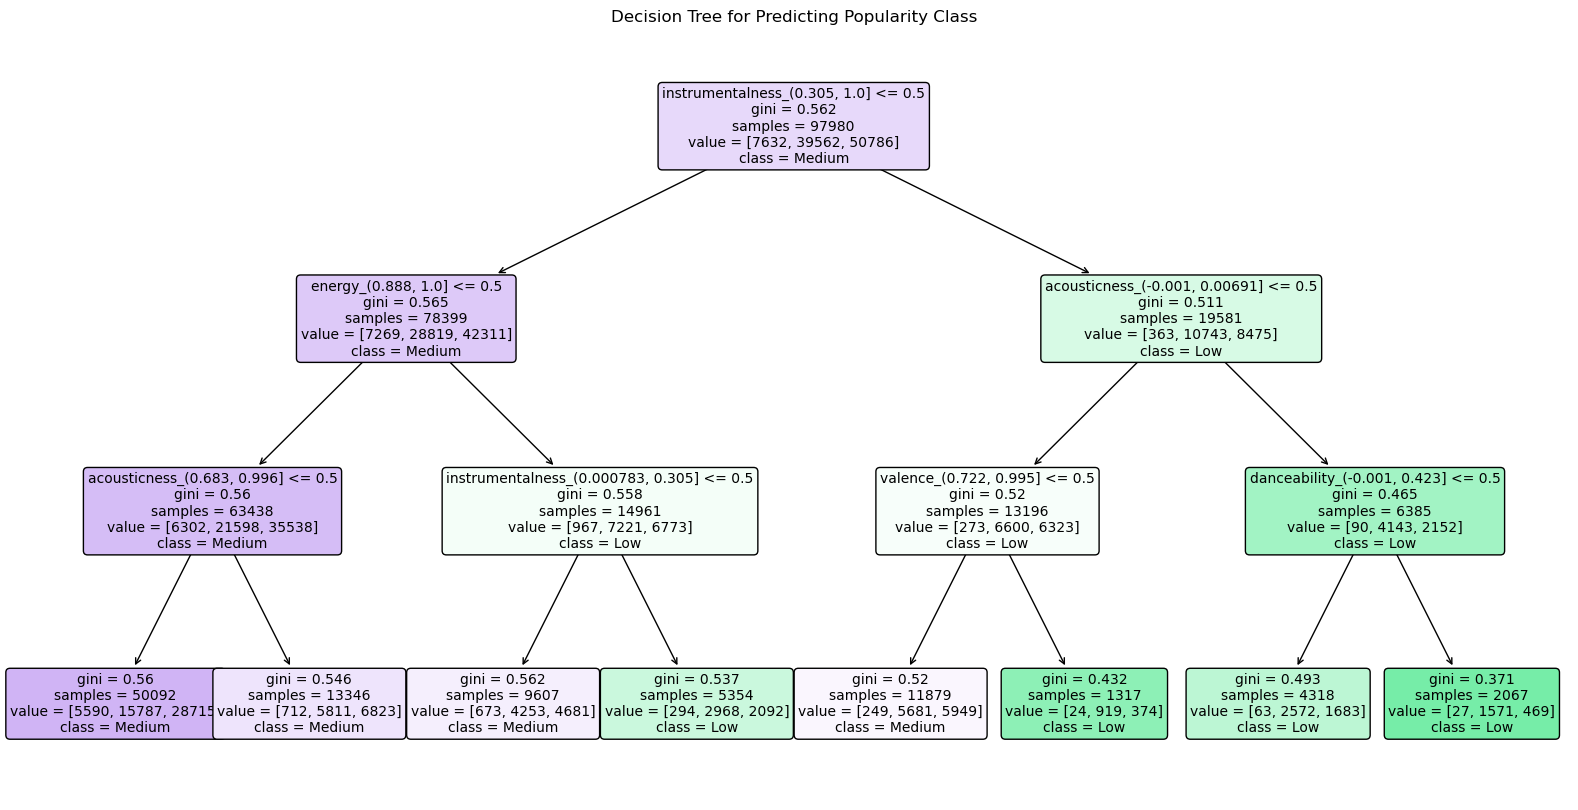

In [18]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder

# Step 1: Encode target labels (Low, Medium, High) into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['popularity_class'])

# Step 2: Prepare binned features
X = binned_df[features].copy()

# Convert all categorical columns (binned values, 'explicit', etc.) to string then one-hot
X = X.astype(str)  # Convert all to string so pd.get_dummies works properly
X = pd.get_dummies(X)

# Step 3: Train Decision Tree
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X, y)

# Step 4: Plot the tree using matplotlib
plt.figure(figsize=(20, 10))
plot_tree(clf,
          feature_names=X.columns,
          class_names=label_encoder.classes_,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree for Predicting Popularity Class")
plt.show()

In [37]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Step 1: Prepare data (use original numeric popularity as target)
X = binned_df[features].astype(str)
X = pd.get_dummies(X)

y = df['popularity']  # numeric target

# Step 2: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train a regression tree
reg_tree = DecisionTreeRegressor(max_depth=12, random_state=42)
reg_tree.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = reg_tree.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.2f}")

R² Score: 0.1033
Mean Squared Error: 334.63


In [38]:
from sklearn.metrics import accuracy_score

y_pred_class = clf.predict(X)
accuracy = accuracy_score(y, y_pred_class)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.0116


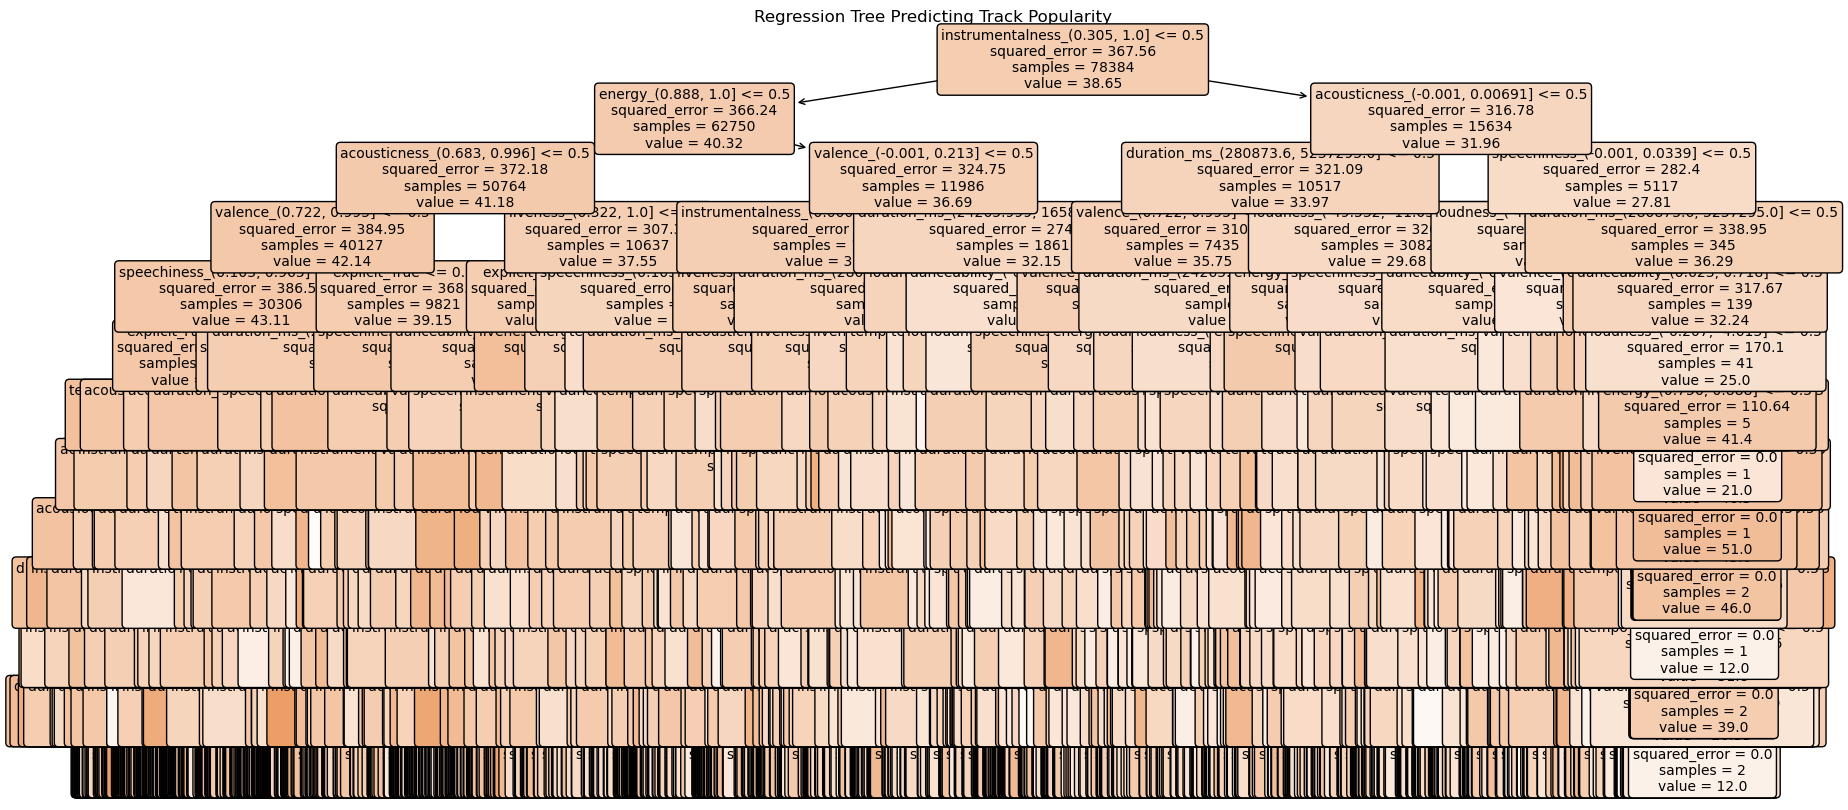

R² Score: 0.1033
Mean Squared Error: 334.63


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Step 1: Prepare features and target
X = binned_df[features].astype(str)
X = pd.get_dummies(X)  # One-hot encode
y = df['popularity']   # Continuous target

# Step 2: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the regression tree
reg_tree = DecisionTreeRegressor(max_depth=12, random_state=42)
reg_tree.fit(X_train, y_train)

# Step 4: Visualize the regression tree
plt.figure(figsize=(20, 10))
plot_tree(reg_tree,
          feature_names=X.columns,
          filled=True,
          rounded=True,
          fontsize=10,
          precision=2)  # precision=2 shows float values cleanly
plt.title("Regression Tree Predicting Track Popularity")
plt.show()

# Step 5: Evaluate model
y_pred = reg_tree.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.2f}")


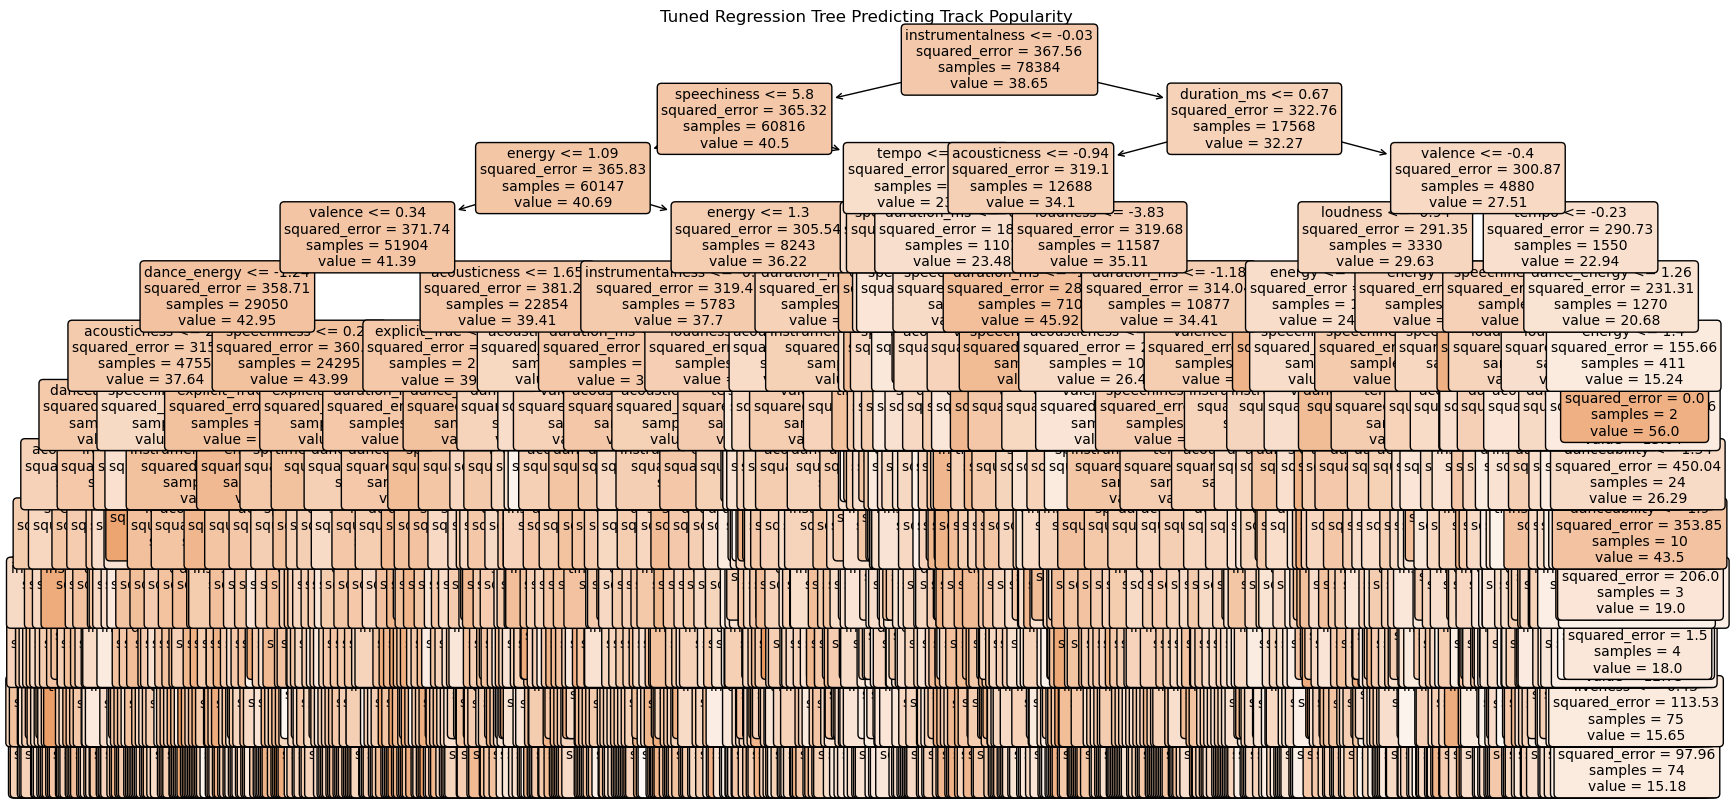

R² Score: 0.1328
Mean Squared Error: 323.63


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Step 1: Feature Engineering
df['dance_energy'] = df['danceability'] * df['energy']
df['is_very_loud'] = (df['loudness'] > -5).astype(int)
df['is_acoustic'] = (df['acousticness'] > 0.7).astype(int)

# Step 2: Define feature list
original_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]
engineered_features = ['dance_energy', 'is_very_loud', 'is_acoustic']
features = original_features + engineered_features

# Step 3: Prepare input/output
X = df[features].copy()
y = df['popularity']

# Step 4: One-hot encode categorical variables
X = pd.get_dummies(X, columns=['explicit', 'key', 'mode', 'time_signature'], drop_first=True)

# Step 5: Normalize numeric features
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X)

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train regression tree with tuned hyperparameters
reg_tree = DecisionTreeRegressor(max_depth=12, min_samples_split=10, random_state=42)
reg_tree.fit(X_train, y_train)

# Step 8: Visualize the regression tree
plt.figure(figsize=(20, 10))
plot_tree(reg_tree,
          feature_names=X.columns,
          filled=True,
          rounded=True,
          fontsize=10,
          precision=2)
plt.title("Tuned Regression Tree Predicting Track Popularity")
plt.show()

# Step 9: Evaluate the model
y_pred = reg_tree.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.2f}")


In [42]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# Define the parameter grid
param_grid = {
    'max_depth': [6, 8, 10, 12, 14],
    'min_samples_split': [2, 5, 10, 20]
}

# Base model
base_tree = DecisionTreeRegressor(random_state=42)

# Grid Search
grid_search = GridSearchCV(
    estimator=base_tree,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,  # Use all cores
    verbose=1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best model and evaluation
best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(X_test)

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print("R² Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'max_depth': 12, 'min_samples_split': 20}
R² Score: 0.1363107205971097
Mean Squared Error: 322.31045849729185


In [43]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# Define parameter grid
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1]
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train, y_train)

# Evaluate best model
best_xgb = grid_search_xgb.best_estimator_
y_pred = best_xgb.predict(X_test)

print("Best Parameters:", grid_search_xgb.best_params_)
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
R² Score: 0.27847037373664596
MSE: 269.2595013117434


In [44]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error

param_dist = {
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='r2',
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

print("Best Parameters:", random_search.best_params_)
print("R² Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
R² Score: 0.3758218307891721
Mean Squared Error: 232.93000932167055


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error

param_dist_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=10,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_rf.fit(X_train, y_train)
best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Best Parameters:", random_search_rf.best_params_)
print("R² Score:", r2_score(y_test, y_pred_rf))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_rf))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': None}
R² Score: 0.46255253798705676
Mean Squared Error: 200.5639551522004
